<a href="https://colab.research.google.com/github/codyub/ESAA/blob/main/%EB%B2%A0%EC%9D%B4%EC%8A%A4%EB%9D%BC%EC%9D%B8_%EC%BD%94%EB%93%9C_%EA%B3%B5%EC%9C%A0(%ED%8A%9C%EB%8B%9DX_O).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 데이터 및 라이브러리 로딩

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

plt.rc('font', family='NanumBarunGothic') #matplotlib 한글 깨짐 방지

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import os
os.chdir("/content/drive/MyDrive/ESAA/프로젝트3_영화관객수예측/영화관객수/")

Mounted at /content/drive


In [ ]:
train = pd.read_csv('movies_train.csv',parse_dates=[3]) # 시간이 있어서, datetime으로 가져옴
test = pd.read_csv('movies_test.csv',parse_dates=[3])

## 데이터탐색

- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- 위 데이터는 대부분이 널 값을 갖고 있음 

- box_off_num: 실제 관객 수로, 우리가 test에서 예측해야 할 데이터

In [ ]:
train.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083
3,나는 공무원이다,(주)NEW,코미디,2012-07-12,101,전체 관람가,구자홍,23894.00,2,20,6,217866
4,불량남녀,쇼박스(주)미디어플렉스,코미디,2010-11-04,108,15세 관람가,신근호,1.00,1,251,2,483387


In [ ]:
test.head()

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7
3,의형제,(주)쇼박스,액션,2010-02-04,116,15세 관람가,장훈,6.913420e+05,2,408,2
4,평행 이론,CJ 엔터테인먼트,공포,2010-02-18,110,15세 관람가,권호영,3.173800e+04,1,380,1


# 각 데이터의 구성 알아보기

In [ ]:
train.director.value_counts() # 감독이 472명이나 존재함. 아마 의미가 없을 것임. 

홍상수           7
장률            4
신재호           4
우민호           4
노진수           4
             ..
권오광           1
한윤선           1
박찬경           1
New Pistol    1
백운학           1
Name: director, Length: 472, dtype: int64

# 데이터 전처리

# 의미없는 데이터 제거

In [ ]:
train.corr() # 장르 랭킹보다 dir_prev_bfnum	dir_prev_num가 더 높은 연관성을 갖고 있으므로, 이를 모두 포함해서 모델을 돌려보자

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000


In [ ]:
train.isna().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [ ]:
# 제목 : 의미가 없기 때문에 제거
train = train.drop(['title'],axis= 1)
test = test.drop(['title'],axis= 1)

In [ ]:
# 감독명 : 너무 다양해서 제거
train = train.drop(['director'],axis = 1)
test = test.drop(['director'],axis = 1)

# 시간이 date가 아니라 object로 되어 있어 바꿔줘야 함

> 데이터 다시 로드했음: parse_dates=[3]
> 년/월 변수를 숫자만 떼어서 넣는게 나을까 아니면, datetime 데이터로 바꾸는게 나을까?



In [ ]:
 # 개봉일을 바탕으로 년/월 변수 생성
# train['년'] = train.release_time.dt.year 
train['month'] = train.release_time.dt.month

# test['년'] = test.release_time.dt.year 
test['month'] = test.release_time.dt.month

In [ ]:
train.info() # 어차피 년, 월만 떼어버리면, 숫자로 들어가므로 굳이 시간으로 가져올 필요가 없었을 수 있음

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   distributor     600 non-null    object        
 1   genre           600 non-null    object        
 2   release_time    600 non-null    datetime64[ns]
 3   time            600 non-null    int64         
 4   screening_rat   600 non-null    object        
 5   dir_prev_bfnum  270 non-null    float64       
 6   dir_prev_num    600 non-null    int64         
 7   num_staff       600 non-null    int64         
 8   num_actor       600 non-null    int64         
 9   box_off_num     600 non-null    int64         
 10  month           600 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 51.7+ KB


# 배급사 전처리

In [ ]:
import re

In [ ]:
train['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [ ]:
# 배급사 쓸모 없는 글자 제거
train['distributor'] = train.distributor.str.replace("(주)",'')
test['distributor'] = test.distributor.str.replace("(주)", '')

In [ ]:
def name_distributor(x) :
    if 'CJ' in x or 'CGV' in x :
        return 'CJ'
    elif '쇼박스' in x :
        return '쇼박스'
    elif 'SK' in x :
        return 'SK'
    elif '리틀빅픽' in x :
        return '리틀빅픽처스'
    elif '스폰지' in x :
        return '스폰지'
    elif '싸이더스' in x :
        return '싸이더스'
    elif '에이원' in x :
        return '에이원'
    elif '마인스' in x :
        return '마인스'
    elif '마운틴픽' in x :
        return '마운틴픽처스'
    elif '디씨드' in x :
        return '디씨드'
    elif '드림팩트' in x :
        return '드림팩트'
    elif '메가박스' in x :
        return '메가박스'
    elif '마운틴' in x :
        return '마운틴'
    else :
        return x

In [ ]:
train['distributor'] = train.distributor.apply(name_distributor)
test['distributor'] = test.distributor.apply(name_distributor)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   distributor     600 non-null    object        
 1   genre           600 non-null    object        
 2   release_time    600 non-null    datetime64[ns]
 3   time            600 non-null    int64         
 4   screening_rat   600 non-null    object        
 5   dir_prev_bfnum  270 non-null    float64       
 6   dir_prev_num    600 non-null    int64         
 7   num_staff       600 non-null    int64         
 8   num_actor       600 non-null    int64         
 9   box_off_num     600 non-null    int64         
 10  month           600 non-null    int64         
dtypes: datetime64[ns](1), float64(1), int64(6), object(3)
memory usage: 51.7+ KB


In [ ]:
train.isna().sum()

distributor         0
genre               0
release_time        0
time                0
screening_rat       0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
month               0
dtype: int64

In [ ]:
train.distributor.value_counts()

CJ          68
롯데엔터테인먼트    52
NEW         38
마운틴픽처스      33
쇼박스         28
            ..
OAL올         1
위더스필름        1
콘텐츠윙         1
팝파트너스        1
퍼스트런         1
Name: distributor, Length: 147, dtype: int64

# 장르별 영화 관객수 평균값으로 랭크 인코딩

In [ ]:
train.groupby('genre').box_off_num.mean().sort_values()

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [ ]:
train['genre_rank'] = train.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})
test['genre_rank'] = test.genre.map({'뮤지컬' : 1, '다큐멘터리' : 2, '서스펜스' : 3, '애니메이션' : 4, '멜로/로맨스' : 5,
                                      '미스터리' : 6, '공포' : 7, '드라마' : 8, '코미디' : 9, 'SF' : 10, '액션' : 11, '느와르' : 12})

# 배급사별 영화 관객수 중위값 기준으로 배급사 랭크 인코딩

In [ ]:
tr_nm_rank = train.groupby('distributor').box_off_num.median().reset_index(name = 'num_rank').sort_values(by = 'num_rank')
tr_nm_rank

,distributor,num_rank
110,인피니티엔터테인먼트,2.0
15,고구마공작소,8.0
52,사람과사람들,42.0
97,위드시네마,46.0
19,나우콘텐츠,54.0
...,...,...
113,전망좋은영화사,1214237.0
105,이십세기폭스코리아,1422844.0
56,쇼박스,2138560.0
84,영구아트무비,2541603.0


In [ ]:
tr_nm_rank['num_rank'] = [i + 1 for i in range(tr_nm_rank.shape[0])]

In [ ]:
tr_nm_rank # 랭크가 아래로 갈수록 관객수가 많음

,distributor,num_rank
110,인피니티엔터테인먼트,1
15,고구마공작소,2
52,사람과사람들,3
97,위드시네마,4
19,나우콘텐츠,5
...,...,...
113,전망좋은영화사,143
105,이십세기폭스코리아,144
56,쇼박스,145
84,영구아트무비,146


# 계절변수 추가

In [ ]:
def func(month):
  if month in [3, 4, 5]:
    return '봄'
  elif month in [6, 7, 8]:
    return '여름'
  elif month in [9, 10, 11]:
    return '가을'
  elif month in [12, 1, 2]:
    return '겨울'

In [ ]:
train['season'] = train['month'].apply(lambda x: func(x))
test['season'] = test['month'].apply(lambda x: func(x))

In [ ]:
train.head()

,distributor,genre,release_time,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,season
0,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,NaN,0,91,2,23398,11,11,가을
1,쇼박스,느와르,2015-11-19,130,청소년 관람불가,1161602.50,2,387,3,7072501,11,12,가을
2,쇼박스,액션,2013-06-05,123,15세 관람가,220775.25,4,343,4,6959083,6,11,여름
3,NEW,코미디,2012-07-12,101,전체 관람가,23894.00,2,20,6,217866,7,9,여름
4,쇼박스,코미디,2010-11-04,108,15세 관람가,1.00,1,251,2,483387,11,9,가을


In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,-0.023969,0.404035
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.064117,0.129922
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.034019,0.236391
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,-0.002841,0.466936
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,-0.015063,0.058944
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.019104,0.279454
month,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,1.000000,-0.022913
genre_rank,0.404035,0.129922,0.236391,0.466936,0.058944,0.279454,-0.022913,1.000000


# 데이터 이어 붙이기

In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,-0.023969,0.404035
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.064117,0.129922
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.034019,0.236391
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,-0.002841,0.466936
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,-0.015063,0.058944
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.019104,0.279454
month,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,1.000000,-0.022913
genre_rank,0.404035,0.129922,0.236391,0.466936,0.058944,0.279454,-0.022913,1.000000


In [ ]:
train = pd.merge(train, tr_nm_rank, how = 'left')

In [ ]:
test = pd.merge(test, tr_nm_rank, how = 'left')

In [ ]:
# release time은 변수 처리가 끝났으므로 제거
train =  train.drop(['release_time'],axis = 1)
test =  test.drop(['release_time'],axis = 1)

In [ ]:
train # screening_rat, season은 더미화가 필요

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,season,num_rank
0,롯데엔터테인먼트,액션,96,청소년 관람불가,NaN,0,91,2,23398,11,11,가을,134
1,쇼박스,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501,11,12,가을,145
2,쇼박스,액션,123,15세 관람가,220775.25,4,343,4,6959083,6,11,여름,145
3,NEW,코미디,101,전체 관람가,23894.00,2,20,6,217866,7,9,여름,140
4,쇼박스,코미디,108,15세 관람가,1.00,1,251,2,483387,11,9,가을,145
...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,NEW,드라마,111,청소년 관람불가,3833.00,1,510,7,1475091,8,8,여름,140
596,쇼박스,드라마,127,15세 관람가,496061.00,1,286,6,1716438,3,8,봄,145
597,마운틴픽처스,공포,99,청소년 관람불가,NaN,0,123,4,2475,9,7,가을,46
598,CJ,느와르,102,15세 관람가,NaN,0,431,4,2192525,5,12,봄,141


# 시각화

- 상관계수

In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,num_rank
time,1.000000,0.264675,0.306727,0.623205,0.114153,0.441452,-0.023969,0.404035,0.525554
dir_prev_bfnum,0.264675,1.000000,0.131822,0.323521,0.083818,0.283184,0.064117,0.129922,0.178457
dir_prev_num,0.306727,0.131822,1.000000,0.450706,0.014006,0.259674,0.034019,0.236391,0.361585
num_staff,0.623205,0.323521,0.450706,1.000000,0.077871,0.544265,-0.002841,0.466936,0.653489
num_actor,0.114153,0.083818,0.014006,0.077871,1.000000,0.111179,-0.015063,0.058944,0.080893
box_off_num,0.441452,0.283184,0.259674,0.544265,0.111179,1.000000,0.019104,0.279454,0.407956
month,-0.023969,0.064117,0.034019,-0.002841,-0.015063,0.019104,1.000000,-0.022913,-0.061528
genre_rank,0.404035,0.129922,0.236391,0.466936,0.058944,0.279454,-0.022913,1.000000,0.292513
num_rank,0.525554,0.178457,0.361585,0.653489,0.080893,0.407956,-0.061528,0.292513,1.000000


- 히스토그램

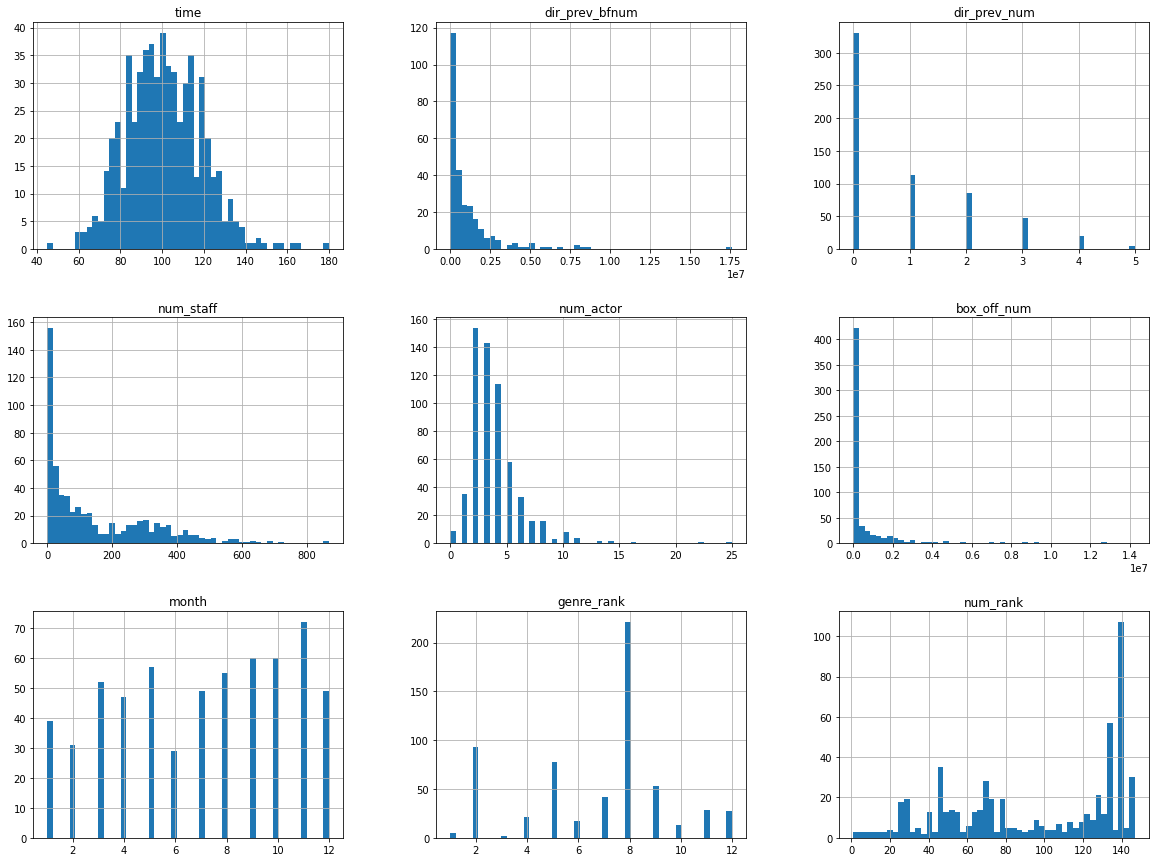

In [ ]:
# 히스토그램 한 번에 그리기
train.hist(bins = 50, figsize = (20,15))
plt.show() # 배우, 스태프 수는 왜도가 심함, 이상치 제거도 필요할 것으로 예상됨

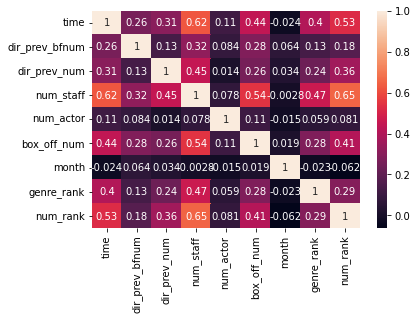

In [ ]:
sns.heatmap(train.corr(), annot = True) # 스태프 수, 시간이 상대적으로 높은 영향을 주고 있음을 알 수 있다. # 시간이 아닌 object는 여기서 나오지 않음.

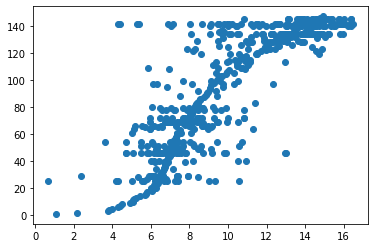

In [ ]:
plt.scatter(np.log1p(train['box_off_num']),train['num_rank']) # 배급사에 따른 랭킹
plt.show()

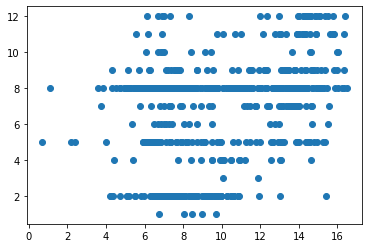

In [ ]:
plt.scatter(np.log1p(train['box_off_num']),train['genre_rank'])
plt.show()

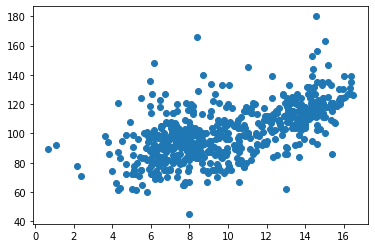

In [ ]:
plt.scatter(np.log1p(train['box_off_num']),train['time'])
plt.show() # 시간이 너무 길면 관객수가 떨어짐. 적정 시간이 존재함. 

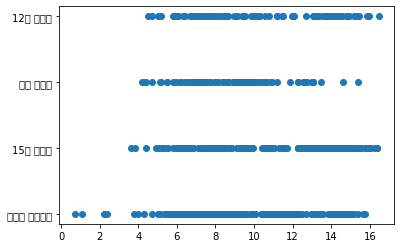

In [ ]:
plt.scatter(np.log1p(train['box_off_num']),train['screening_rat'])
plt.show() # 연령에 따른 문제는 딱히 보이지 않음. 상대적으로 전체 관람 영화/청소년 관람 불가 영화의 관객 수가 떨어지는 경향이 있음.

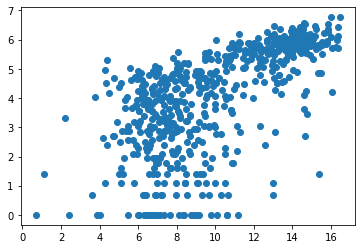

In [ ]:
plt.scatter(np.log1p(train['box_off_num']),np.log1p(train['num_staff']))
plt.show()# 스태프 수가 많으면 관객수가 많은 편, 로그화 한다고 더 좋은 그래프가 되는 것 같지는 않음. 

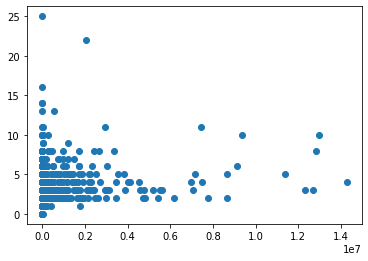

In [ ]:
plt.scatter(train['box_off_num'],train['num_actor'])
plt.show() # 배우 수가 일정 이상 많을 필요는 없는 것으로 추정

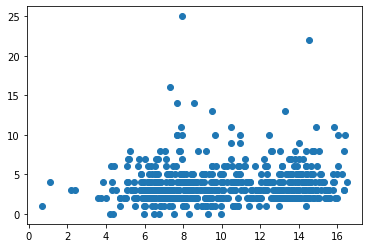

In [ ]:
plt.scatter(np.log1p(train.box_off_num),train['num_actor'])
plt.show() # 별로 상관 없어보임. 로그화 시켰을 때  좀 더 데이터 분포가 안정적인 것으로 추정

# 테스트 전처리

In [ ]:
test # 테스트에는 새로운 배급사가 존재함. 

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month,genre_rank,season,num_rank
0,시네마서비스,느와르,125,청소년 관람불가,3.005290e+05,2,304,3,1,12,겨울,132.0
1,쇼박스,멜로/로맨스,113,12세 관람가,3.427002e+05,4,275,3,1,5,겨울,145.0
2,CJ,드라마,115,12세 관람가,4.206611e+06,3,419,7,1,8,겨울,141.0
3,쇼박스,액션,116,15세 관람가,6.913420e+05,2,408,2,2,11,겨울,145.0
4,CJ,공포,110,15세 관람가,3.173800e+04,1,380,1,2,7,겨울,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...
238,디씨드,드라마,78,15세 관람가,2.590000e+03,1,4,4,11,8,가을,112.0
239,인디스토리,다큐멘터리,86,12세 관람가,NaN,0,18,2,10,2,가을,69.0
240,컨텐츠온미디어,느와르,107,청소년 관람불가,NaN,0,224,4,10,12,가을,NaN
241,마운틴픽처스,드라마,102,청소년 관람불가,5.069900e+04,1,68,7,10,8,가을,46.0


In [ ]:
test.isna().sum() # 관객 수 랭킹에 뭘 부여할 것인가?

distributor         0
genre               0
time                0
screening_rat       0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
month               0
genre_rank          0
season              0
num_rank           31
dtype: int64

In [ ]:
test.fillna(0, inplace = True)
train.fillna(0, inplace = True)

In [ ]:
test.isna().sum() 

distributor       0
genre             0
time              0
screening_rat     0
dir_prev_bfnum    0
dir_prev_num      0
num_staff         0
num_actor         0
month             0
genre_rank        0
season            0
num_rank          0
dtype: int64

# 차원 축소

In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,num_rank
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,-0.023969,0.404035,0.525554
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.047183,0.174314,0.240184
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.034019,0.236391,0.361585
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,-0.002841,0.466936,0.653489
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,-0.015063,0.058944,0.080893
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.019104,0.279454,0.407956
month,-0.023969,0.047183,0.034019,-0.002841,-0.015063,0.019104,1.000000,-0.022913,-0.061528
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,-0.022913,1.000000,0.292513
num_rank,0.525554,0.240184,0.361585,0.653489,0.080893,0.407956,-0.061528,0.292513,1.000000


In [ ]:
from sklearn.preprocessing import StandardScaler

# 속성 값을 standardscaler를 이용해 표준 정규 분포를 가지는 값들로 변환
train_scaled=StandardScaler().fit_transform(train.iloc[:, 5:7])

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(train_scaled)
train_pca=pca.transform(train_scaled)
print(train_pca.shape)

(600, 2)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 각각 pca_component_1, pca_component_2로 명명.
pca_columns=['pca_component_1', 'pca_component_2']
train_pca=pd.DataFrame(train_pca, columns=pca_columns)
train_pca['box_off_num']=train.box_off_num
train_pca.head(3)

,pca_component_1,pca_component_2,box_off_num
0,-0.781093,0.267427,23398
1,1.679486,0.335944,7072501
2,2.687543,-1.048060,6959083


In [ ]:
train_pca.corr()

,pca_component_1,pca_component_2,box_off_num
pca_component_1,1.000000e+00,3.704175e-16,0.471974
pca_component_2,3.704175e-16,1.000000e+00,0.271521
box_off_num,4.719741e-01,2.715211e-01,1.000000


In [ ]:
train['pca_component_1'] = train_pca['pca_component_1']
train.head()

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,season,num_rank,pca_component_1
0,롯데엔터테인먼트,액션,96,청소년 관람불가,0.00,0,91,2,23398,11,11,가을,134,-0.781093
1,쇼박스,느와르,130,청소년 관람불가,1161602.50,2,387,3,7072501,11,12,가을,145,1.679486
2,쇼박스,액션,123,15세 관람가,220775.25,4,343,4,6959083,6,11,여름,145,2.687543
3,NEW,코미디,101,전체 관람가,23894.00,2,20,6,217866,7,9,여름,140,0.111617
4,쇼박스,코미디,108,15세 관람가,1.00,1,251,2,483387,11,9,가을,145,0.500462


In [ ]:
train.corr()

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num,month,genre_rank,num_rank,pca_component_1
time,1.000000,0.266065,0.306727,0.623205,0.114153,0.441452,-0.023969,0.404035,0.525554,0.545942
dir_prev_bfnum,0.266065,1.000000,0.396616,0.369657,0.042491,0.293791,0.047183,0.174314,0.240184,0.449861
dir_prev_num,0.306727,0.396616,1.000000,0.450706,0.014006,0.259674,0.034019,0.236391,0.361585,0.851677
num_staff,0.623205,0.369657,0.450706,1.000000,0.077871,0.544265,-0.002841,0.466936,0.653489,0.851677
num_actor,0.114153,0.042491,0.014006,0.077871,1.000000,0.111179,-0.015063,0.058944,0.080893,0.053939
box_off_num,0.441452,0.293791,0.259674,0.544265,0.111179,1.000000,0.019104,0.279454,0.407956,0.471974
month,-0.023969,0.047183,0.034019,-0.002841,-0.015063,0.019104,1.000000,-0.022913,-0.061528,0.018304
genre_rank,0.404035,0.174314,0.236391,0.466936,0.058944,0.279454,-0.022913,1.000000,0.292513,0.412907
num_rank,0.525554,0.240184,0.361585,0.653489,0.080893,0.407956,-0.061528,0.292513,1.000000,0.595927
pca_component_1,0.545942,0.449861,0.851677,0.851677,0.053939,0.471974,0.018304,0.412907,0.595927,1.000000


In [ ]:
test_scaled=StandardScaler().fit_transform(test.iloc[:, 5:7])

from sklearn.decomposition import PCA

pca = PCA(n_components=2)

# fit과 transform 호출해 PCA 변환 데이터 반환
pca.fit(test_scaled)
test_pca=pca.transform(test_scaled)
print(test_pca.shape)

(243, 2)


In [ ]:
# PCA 변환된 데이터의 칼럼 명을 각각 pca_component_1, pca_component_2로 명명.
pca_columns=['pca_component_1', 'pca_component_2']
test_pca=pd.DataFrame(test_pca, columns=pca_columns)
test_pca.head(3)

,pca_component_1,pca_component_2
0,1.306800,0.048735
1,2.361346,1.355445
2,2.397094,0.139069


In [ ]:
test['pca_component_1'] = test_pca['pca_component_1']
test.head()

,distributor,genre,time,screening_rat,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,month,genre_rank,season,num_rank,pca_component_1
0,시네마서비스,느와르,125,청소년 관람불가,3.005290e+05,2,304,3,1,12,겨울,132.0,1.306800
1,쇼박스,멜로/로맨스,113,12세 관람가,3.427002e+05,4,275,3,1,5,겨울,145.0,2.361346
2,CJ,드라마,115,12세 관람가,4.206611e+06,3,419,7,1,8,겨울,141.0,2.397094
3,쇼박스,액션,116,15세 관람가,6.913420e+05,2,408,2,2,11,겨울,145.0,1.758956
4,CJ,공포,110,15세 관람가,3.173800e+04,1,380,1,2,7,겨울,141.0,1.046908


# actor 제거 ver + dir_prev_bfnum	dir_prev_num를 주성분1개로 변경

In [ ]:
X = train[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1']]
y = np.log1p(train.box_off_num) # 관객 수가 너무 많고 편차가 커서 로그화 시킴

In [ ]:
X = pd.get_dummies(columns = ['screening_rat'], data = X)
X = pd.get_dummies(columns = ['season'], data = X)

In [ ]:
target = test[['num_rank', 'time', 'num_staff', 'genre_rank', 'screening_rat','season', 'pca_component_1']]
target = pd.get_dummies(columns = ['screening_rat'], data = target)
target = pd.get_dummies(columns = ['season'], data = target)

# 모델

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

# 모델_하이퍼파라미터튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params, 
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

In [ ]:
#xgboost 회귀 트리
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[2000,1000,600,500,400,300,100,50]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

[12:56:27] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:28] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:56:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

In [ ]:
#ligthgbm 회귀 트리
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[2000,1000,600,500,400,300,100,50]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 1.5536, 최적 alpha:{'n_estimators': 300}


In [ ]:
# rf
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

rf_params = { 'n_estimators' : [10, 100],
           'max_depth' : [6, 8, 10, 12],
           'min_samples_leaf' : [8, 12, 18],
           'min_samples_split' : [8, 16, 20]
            }
rf_reg = RandomForestRegressor(n_estimators=100)

best_rf = print_best_params(rf_reg, rf_params)

RandomForestRegressor 5 CV 시 최적 평균 RMSE 값: 1.5388, 최적 alpha:{'max_depth': 8, 'min_samples_leaf': 8, 'min_samples_split': 20, 'n_estimators': 100}


In [ ]:
# gb,

gbm_params = { 'n_estimators' : range(5,50,10),
           'max_features' : range(1,4),
           'max_depth' : range(3,5),
           'learning_rate' : np.linspace(0.1,1,10)
            }
gbm_reg = GradientBoostingRegressor(random_state = 42)

best_gbm = print_best_params(gbm_reg, gbm_params)

GradientBoostingRegressor 5 CV 시 최적 평균 RMSE 값: 1.5305, 최적 alpha:{'learning_rate': 0.1, 'max_depth': 4, 'max_features': 3, 'n_estimators': 45}


In [ ]:
def get_rmse_pred(preds):
  from sklearn.metrics import mean_squared_error
  for key in preds.keys():
    pred_value = preds[key]
    mse = mean_squared_error(y, pred_value)
    rmse = np.sqrt(mse)
    print('{0} models rmse: {1}'.format(key, rmse))

train_rmse

In [ ]:
xgb_reg = XGBRegressor(n_estimators=100, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=300, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
rf_reg = RandomForestRegressor(max_depth=8, min_samples_leaf=8, min_samples_split=20, n_estimators=100)
gbm_reg = GradientBoostingRegressor(learning_rate=0.1, max_depth=4, max_features=3, n_estimators=45)

xgb_reg.fit(X, y)
lgbm_reg.fit(X, y)
rf_reg.fit(X, y)
gbm_reg.fit(X, y)

xgb_pred = xgb_reg.predict(X)
lgbm_pred = lgbm_reg.predict(X)
rf_pred = rf_reg.predict(X)
gbm_pred = gbm_reg.predict(X)

pred = 0.25 * xgb_pred + 0.25 * lgbm_pred + 0.25 *rf_pred +0.25 *gbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred,
         'RF': rf_pred,
         'GBM': gbm_pred}
        
get_rmse_pred(preds)

[13:01:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
최종 혼합 models rmse: 1.2145050923316711
XGBM models rmse: 1.2666917879252115
LGBM models rmse: 1.310057311844402
RF models rmse: 1.272996031366766
GBM models rmse: 1.089514972496726


# 학습 된 모델로 예측 데이터 생성

In [ ]:
xgb_pred = xgb_reg.predict(target)
lgbm_pred = lgbm_reg.predict(target)
rf_pred = rf_reg.predict(target)
gbm_pred = gbm_reg.predict(target)

pred14 = 0.25 * xgb_pred + 0.25 * lgbm_pred + 0.25 *rf_pred +0.25 *gbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred,
         'RF': rf_pred,
         'GBM': gbm_pred}

# 제출파일 생성

In [ ]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [ ]:
submission['box_off_num'] = np.expm1(pred14)

In [ ]:
submission

,title,box_off_num
0,용서는 없다,1.484449e+06
1,아빠가 여자를 좋아해,1.752147e+06
2,하모니,1.439632e+06
3,의형제,2.406887e+06
4,평행 이론,1.206165e+06
...,...,...
238,해에게서 소년에게,1.574507e+04
239,울보 권투부,2.937977e+03
240,어떤살인,3.591755e+02
241,말하지 못한 비밀,1.891643e+03


In [ ]:
submission.to_csv('베이스라인15_튜닝.csv',index = False)

# 디폴트 옵션 모델

# 10-fold 교차검증

In [ ]:
kf = KFold(n_splits =  10, shuffle = True, random_state = 42)

In [ ]:
gbm = GradientBoostingRegressor(random_state = 42)

rmse_list = []
gb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    gbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in gbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in gbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    gb_pred += (sub_pred / 10)

np.mean(rmse_list)

962457.8261445621

In [ ]:
lgbm = LGBMRegressor(random_state = 518)

rmse_list = []
lgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    lgbm.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in lgbm.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    lgb_pred += (sub_pred / 10)

np.mean(rmse_list)

1176592.9395195981

In [ ]:
xgb = XGBRegressor(random_state = 518)

rmse_list = []
xgb_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    xgb.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in xgb.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in xgb.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    xgb_pred += (sub_pred / 10)

np.mean(rmse_list)

[12:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:48] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[12:03:49] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

956831.487446205

In [ ]:
rf = RandomForestRegressor(random_state = 518)

rmse_list = []
rf_pred = np.zeros((test.shape[0]))
for tr_idx, val_idx in kf.split(X, y) :
    tr_x, tr_y = X.iloc[tr_idx], y.iloc[tr_idx]
    val_x, val_y = X.iloc[val_idx], y.iloc[val_idx]
    
    rf.fit(tr_x, tr_y)
    
    pred = np.expm1([0 if x < 0 else x for x in rf.predict(val_x)])
    sub_pred = np.expm1([0 if x < 0 else x for x in rf.predict(target)])
    rmse = np.sqrt(mean_squared_error(val_y, pred))
    
    rmse_list.append(rmse)
    
    rf_pred += (sub_pred / 10)

np.mean(rmse_list)

877854.728277832

# 학습 된 모델로 예측 데이터 생성

In [ ]:
pred15 = (xgb_pred + lgb_pred + rf_pred + gb_pred) / 4

# 제출파일 생성

In [ ]:
submission = pd.read_csv('submission.csv')
submission

,title,box_off_num
0,용서는 없다,0
1,아빠가 여자를 좋아해,0
2,하모니,0
3,의형제,0
4,평행 이론,0
...,...,...
238,해에게서 소년에게,0
239,울보 권투부,0
240,어떤살인,0
241,말하지 못한 비밀,0


In [ ]:
submission['box_off_num'] = pred15

In [ ]:
submission

,title,box_off_num
0,용서는 없다,1.799510e+06
1,아빠가 여자를 좋아해,1.715451e+06
2,하모니,2.558183e+06
3,의형제,2.066026e+06
4,평행 이론,1.151047e+06
...,...,...
238,해에게서 소년에게,1.002709e+04
239,울보 권투부,4.111214e+03
240,어떤살인,9.243808e+01
241,말하지 못한 비밀,2.205195e+03


In [ ]:
submission.to_csv('베이스라인15_pca.csv',index = False)